In [32]:
using Plots, DifferentialEquations, LaTeXStrings, Printf, SpecialFunctions, Base.MathConstants

# Define constants
S = 10^7
Fhat = 1.0

function f_real(du, u, p, t)
    Q, U = p
    W_real, W_imag = u

    # Compute b and r for current t and Q
    denom_b = Q * (t^2 + Q) + Fhat^2
    b = 2 / denom_b
    r = 2 * Fhat * b

    # Special case when U=0 (simplified equations)
    if U == 0.0
        term1 = (Q + t^2) / t
        term2 = t^2 * Q
        term3 = 0.0
        term4 = (t^2 - Q) * complex(W_real, W_imag) / (Q + t^2)
        term5 = complex(W_real^2 - W_imag^2, 2 * W_real * W_imag) / (Q + t^2)
    else
        # General case
        denom = Q + t^2 * (1 + b * Q * U^2)
        term1 = (Q + t^2 * (1 + b * Q * U^2)) / t
        term2 = t^2 * Q + b * t^4 * (t^2 + Q) * U^2
        numerator3 = t^3 * r * U^2 * (-4im * Q + t^2 * (-2im + U^2 * (t * (t^2 + Q) * r + b * Q * (-2im + t^3 * r * U^2))))
        term3 = numerator3 / denom^2
        numerator4 = (t^2 - Q + t^2 * (b * Q - 2im * t * (t^2 + Q) * r) * U^2 - 2im * b * t^5 * Q * r * U^4)
        term4 = numerator4 * complex(W_real, W_imag) / denom^2
        term5 = complex(W_real^2 - W_imag^2, 2 * W_real * W_imag) / denom
    end

    total = term1 * (term2 + term3 + term4) - term5
    du[1] = real(total)
    du[2] = imag(total)
end

# Q and U values
Q = 1e-2
U = 0.0
Q_values = 10.0 .^ range(-4, -0.02, length=100)
U_values = [0.0; 10.0 .^ range(-4, -0.02, length=99)]  # Ensure U=0 is included

# Time span (integrate from large to small t)
tspan = (20.0, 1e-7)

function solve_and_compute_Δ(p1, p2)
    # For U=0 case, use known analytical initial condition
    if p2 == 0.0
        w0_real = -sqrt(Q) * tspan[1]^2 - 0.5
        w0_imag = 0.0
    else
        t_init = tspan[1]
        denom_b = p1 * (t_init^2 + p1) + Fhat^2
        b_init = 2 / denom_b
        r_init = 2 * Fhat * b_init
        w0_real = -sqrt(Q) * tspan[1]^2 - 0.5
        w0_imag = 0.0
    end
    w0 = [w0_real, w0_imag]

    prob = ODEProblem(f_real, w0, tspan, (p1, p2))

    try
        sol = solve(prob, Rodas5(), reltol=1e-8, abstol=1e-8, maxiters=1e6)

        if !(sol.retcode == ReturnCode.Success)
            @warn "Early termination for p1=$p1, p2=$p2 with retcode $(sol.retcode)"
            return complex(NaN, NaN)
        end

        t_min = minimum(sol.t)
        W_prime_real, W_prime_imag = sol(t_min, Val{1})
        W_prime = complex(W_prime_real, W_prime_imag)

        Δhat = π / W_prime
        return Δhat
    catch e
        @warn "Failed for parameters p1=$p1, p2=$p2: $e"
        try
            sol = solve(prob, Tsit5(), reltol=1e-8, abstol=1e-8, maxiters=1e6)
            t_min = minimum(sol.t)
            W_prime_real, W_prime_imag = sol(t_min, Val{1})
            W_prime = complex(W_prime_real, W_prime_imag)
            return π / W_prime
        catch e2
            @warn "Fallback solver also failed for p1=$p1, p2=$p2: $e2"
            return complex(NaN, NaN)
        end
    end
end

# Compute results
Δhat_valuesU = [solve_and_compute_Δ(Q, U_val) for U_val in U_values]
Δhat_valuesQ = [solve_and_compute_Δ(Q_val, U) for Q_val in Q_values]

# Process results
function process_results(Δhat_values)
    real_part = [isnan(x) ? NaN : real(x) for x in Δhat_values]
    imag_part = [isnan(x) ? NaN : imag(x) for x in Δhat_values]
    log_real = log10.(abs.(real_part))
    log_imag = log10.(abs.(imag_part))
    return log_real, log_imag
end

logΔ_realU, logΔ_imagU = process_results(Δhat_valuesU)
logΔ_realQ, logΔ_imagQ = process_results(Δhat_valuesQ)

([1.2072658589728782, 1.1289502928139523, 1.04701621764975, 0.9673655916401604, 0.8879703997088823, 0.8101199491986016, 0.7302212302264255, 0.6513175202966416, 0.570511465575672, 0.4902778059055287  …  -8.376843175725273, -8.708085276261865, -9.061752285760845, -9.438818069766624, -9.839689662966661, -10.263674497259467, -10.707993173978561, -11.166020990697552, -11.624612595983963, -12.061855983343884], [-Inf, -Inf, -Inf, -Inf, -Inf, -Inf, -Inf, -Inf, -Inf, -Inf  …  -Inf, -Inf, -Inf, -Inf, -Inf, -Inf, -Inf, -Inf, -Inf, -Inf])

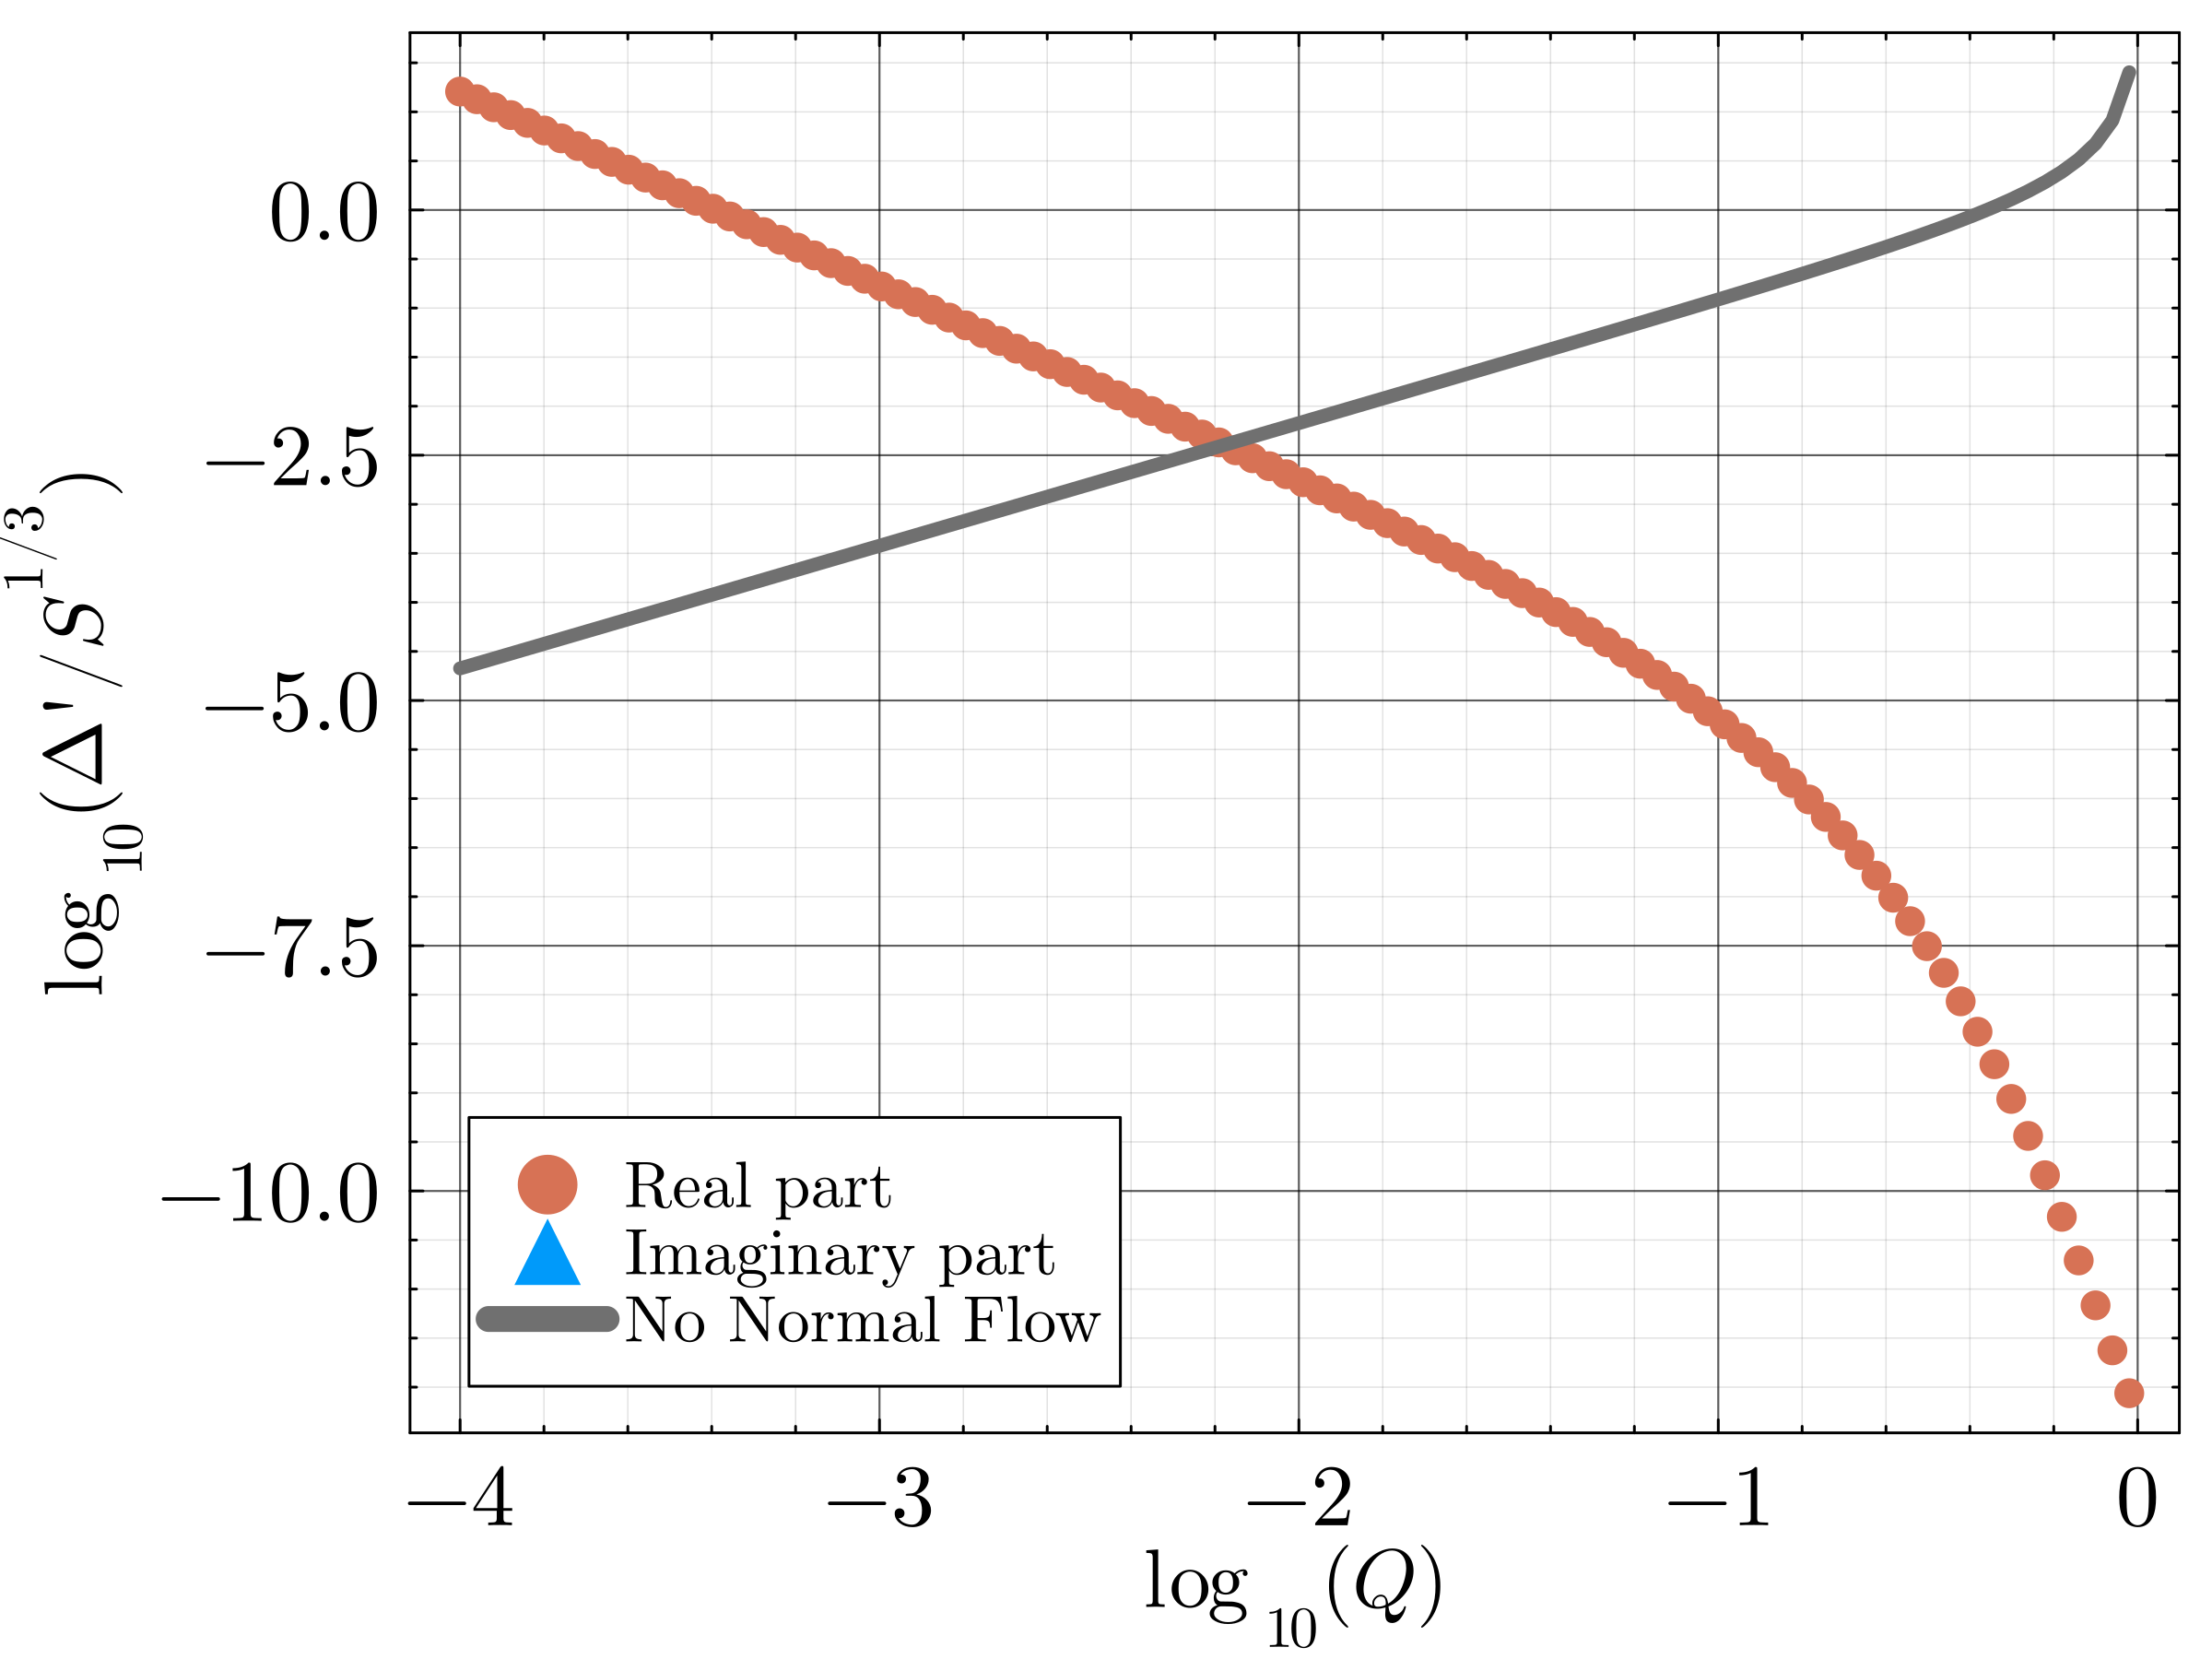

In [33]:
# Create the plot

theme(:dao)

p = plot(size=(800, 600), dpi=300)

# Plot real part (swapped x and y)
scatter!(p, log10.(Q_values), logΔ_realQ,
    label="Real part",
    markersize=6,
    marker=:circle,
    linestyle=:dash,
    linewidth=3)

# Plot imaginary part (swapped x and y)
scatter!(p, log10.(Q_values), logΔ_imagQ,
    label="Imaginary part",
    markersize=6,
    marker=:utriangle,
    linestyle=:dash,
    linewidth=3)

# First, compute the exact solution for single mode case
function exact_sm_coppi(Q)
    numerator = -π * gamma(Q^(3 / 2) / 4 - 1 / 4) * Q^(5 / 4)
    denominator = 8 * gamma(Q^(3 / 2) / 4 + 5 / 4)
    return numerator / denominator
end

# Compute exact solution for valid Q values
sm_coppi_exact = exact_sm_coppi.(Q_values)

# Plot the exact solution line (swapped x and y)
plot!(p, log10.(Q_values), log10.(abs.(sm_coppi_exact)),
    label="No Normal Flow",
    linewidth=5,
    linestyle=:solid)

# Add plot formatting with swapped labels
plot!(p,
    #title=L"Dispersion Relation$",
    ylabel=L"\log_{10}{(\Delta'/S^{1/3})}",  # Swapped y and x labels
    xlabel=L"\log_{10}(Q)",              # Swapped y and x labels
    legend=:best,
    titlefontsize=25,
    tickfontsize=20,
    legendfontsize=15,
    yguidefontsize=20,
    xguidefontsize=20,
    # grid=true,
    # gridstyle=:dash,
    # gridalpha=0.25,
    # minorgrid=false,
    left_margin=2 * Plots.mm,
    bottom_margin=2 * Plots.mm
)

# Display the plot
p

#savefig(p, "disprel_cf_U1.png")